In [2]:
# Initial Python environment setup...
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import json
import datetime
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt # Graph plot
from scipy.stats import pearsonr
from sklearn import preprocessing
import lightgbm as lgb

In [3]:
# Referred: https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook
def load_df(csv_path, nrows = None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [4]:
%%time
train_df = load_df('./data/train.csv')

CPU times: user 2min 7s, sys: 5.9 s, total: 2min 13s
Wall time: 2min 14s


In [ ]:
%%time
train_df.to_csv("./data/train-flattened.csv", index = False)

In [5]:
%%time
test_df = load_df('./data/test.csv')

CPU times: user 1min 49s, sys: 3.45 s, total: 1min 52s
Wall time: 1min 51s


In [ ]:
%%time
test_df.to_csv("./data/test-flattened.csv", index = False)

In [6]:
train_df.describe()

,date,visitId,visitNumber,visitStartTime
count,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05
mean,2.016589e+07,1.485007e+09,2.264897,1.485007e+09
std,4.697698e+03,9.022124e+06,9.283735,9.022124e+06
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09
25%,2.016103e+07,1.477561e+09,1.000000,1.477561e+09
50%,2.017011e+07,1.483949e+09,1.000000,1.483949e+09
75%,2.017042e+07,1.492759e+09,1.000000,1.492759e+09
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09


# Task - 1: Data Cleaning

In [7]:
# Adding new Features to the data
def new_features(df):
    df["visitStartDate"] = pd.to_datetime(train_df['visitStartTime'], unit='s')
    df['month'] = train_df.visitStartDate.apply(lambda x: x.month)
    df['weekday'] = train_df.visitStartDate.apply(lambda x: x.isoweekday())
    df['hour'] = train_df.visitStartDate.apply(lambda x: x.hour)
    df['date'] = df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
    
    return df

train_df = new_features(train_df);
test_df = new_features(test_df);

In [8]:
def clean_data(df):
    # Remove columns with constant values.
    const_cols = [c for c in df.columns if df[c].nunique(dropna = False) == 1]
    print("Columns with constant values: ")
    print(const_cols)
    
    df = df.drop(const_cols, axis = 1)
    
    # Remove columns with ids.
    df = df.drop(['sessionId', 'trafficSource.campaignCode'], axis = 1)
    
    # Removing invalid values from the browser column
    df = df[df['device.browser'] != '0']
    df = df[df['device.browser'] != '(not set)']
    
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].astype('float')
    
    # Impute 0 for missing target values
    df['totals.transactionRevenue'].fillna(0, inplace = True)
    df['totals.pageviews'].fillna(0, inplace = True)
    
    #frequentHits = df['totals.hits'].value_counts().head(1)[0]
    df['totals.hits'].fillna(1.0, inplace = True)
    
    #frequentVisitNumber = df['visitNumber'].value_counts().head(1)[0]
    df['visitNumber'].fillna(1.0, inplace = True)

    return df

train_df = clean_data(train_df)

Columns with constant values: 
['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters']


# Task - 2, 3: Data Visualization

In [9]:
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
nzr = (gdf["totals.transactionRevenue"] > 0).sum()
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / train_df.shape[0])

print("Number of unique visitors in train set : ", train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])

Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.011061951799282457
Number of unique visitors in train set :  714152  out of rows :  903638


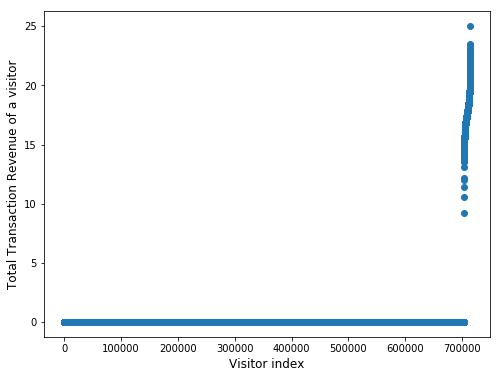

In [10]:
# Transaction revenue visitor distribution distribution
plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('Visitor index', fontsize=12)
plt.ylabel('Total Transaction Revenue of a visitor', fontsize=12)
plt.show()

Total Countries with zero revenues: 153
Total Countries with non-zero revenues: 69


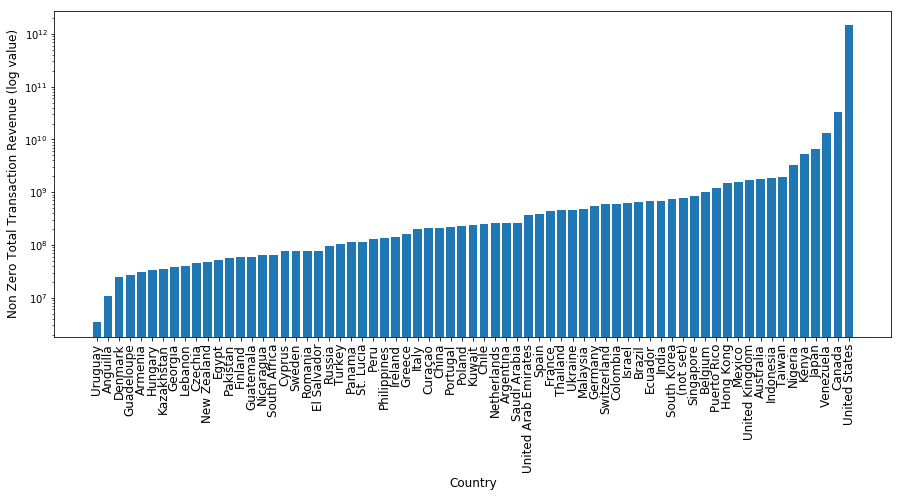

In [11]:
def make_barchart(xKeys, y, xLabel, yLabel, log = False, figsize = [8.0, 5.0]):
    x = np.arange(xKeys.shape[0])
    plt.rcParams['figure.figsize'] = figsize
    plt.bar(x, y, log = log)
    plt.ylabel(yLabel, fontsize=12)
    plt.xlabel(xLabel, fontsize=12)
    plt.xticks(x, xKeys, fontsize=12, rotation="vertical")
    plt.show()

gdf = train_df.groupby("geoNetwork.country")["totals.transactionRevenue"].sum().reset_index()
zero_revenue_countries = gdf[gdf["totals.transactionRevenue"] == 0]["geoNetwork.country"];
print("Total Countries with zero revenues: %d" %len(zero_revenue_countries));

gdf = gdf[gdf["totals.transactionRevenue"] > 0]
gdf = gdf.sort_values(by=['totals.transactionRevenue'])
print("Total Countries with non-zero revenues: %d" %len(gdf["geoNetwork.country"]));

countries = gdf["geoNetwork.country"].values
transaction_revenue = gdf["totals.transactionRevenue"].values
make_barchart(countries, transaction_revenue, 'Country', 'Non Zero Total Transaction Revenue (log value)', True, [15.0, 6.0])

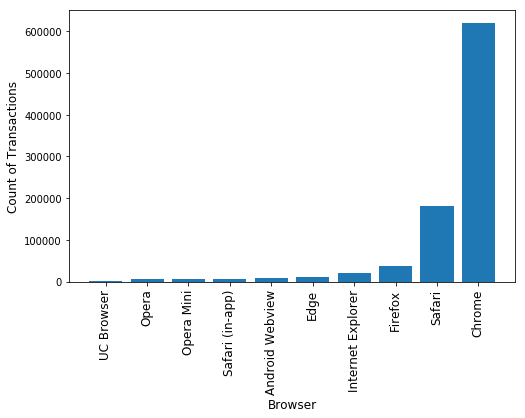

In [12]:
gdf = train_df.groupby('device.browser')["totals.transactionRevenue"].agg(['count']).reset_index()

count_gdf = gdf.sort_values(by=['count']).tail(10)
browser = count_gdf["device.browser"]

make_barchart(browser, count_gdf['count'], 'Browser', 'Count of Transactions')

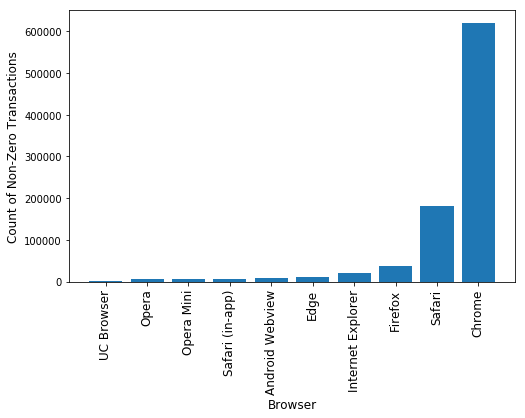

In [13]:
gdf = train_df[train_df["totals.transactionRevenue"] > 0]
gdf = train_df.groupby('device.browser')["totals.transactionRevenue"].agg(['size', 'count', 'mean']).reset_index()

count_gdf = gdf.sort_values(by=['count']).tail(10)
browser = count_gdf["device.browser"]

make_barchart(browser, count_gdf['count'], 'Browser', 'Count of Non-Zero Transactions')

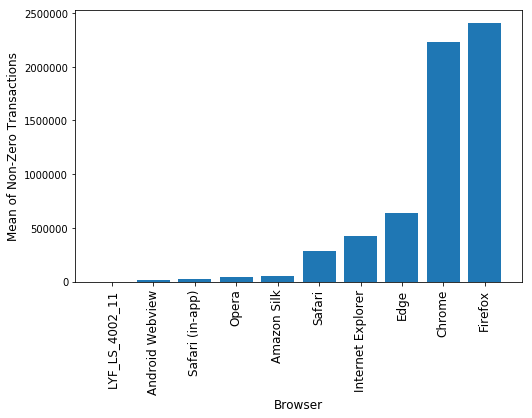

In [14]:
mean_gdf = gdf.sort_values(by=['mean']).tail(10)

browser = mean_gdf["device.browser"].values
make_barchart(browser, mean_gdf['mean'].values, 'Browser', 'Mean of Non-Zero Transactions')

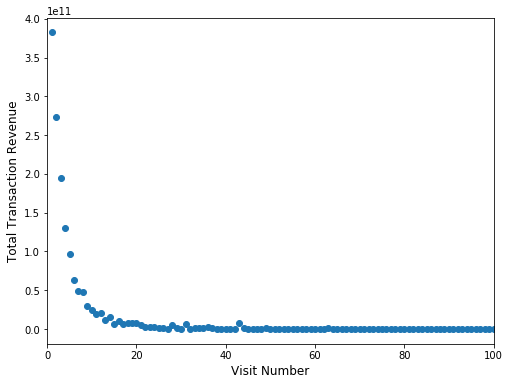

In [15]:
gdf = train_df.groupby("visitNumber")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(gdf["visitNumber"], gdf["totals.transactionRevenue"])
plt.xlabel('Visit Number', fontsize=12)
plt.ylabel('Total Transaction Revenue', fontsize=12)
plt.xlim(0,100)
plt.show()

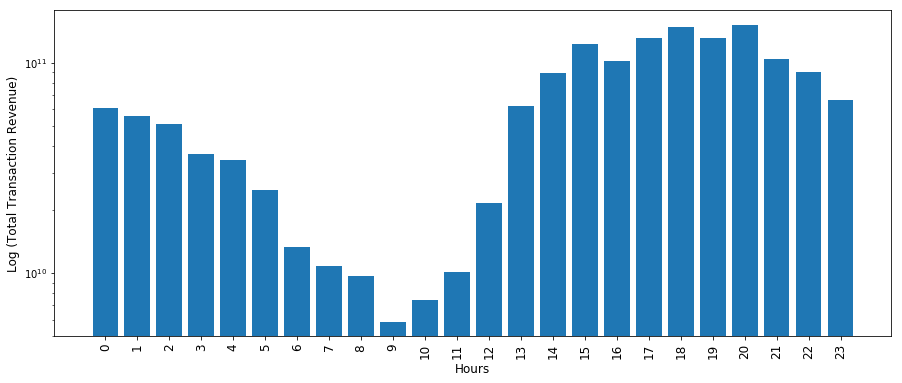

Pearson coefficient between Hours and Transaction Revenue: (0.6548119265808495, 0.0005163177345000834)


In [16]:
gdf = train_df.groupby("hour")["totals.transactionRevenue"].sum().reset_index()

hr_list = train_df.groupby("hour")["totals.transactionRevenue"].sum().reset_index()
hrs = hr_list['hour'].values
tr = hr_list["totals.transactionRevenue"].values
make_barchart(hrs, tr, 'Hours', 'Log (Total Transaction Revenue)', True, [15.0, 6.0])

print("Pearson coefficient between Hours and Transaction Revenue:", pearsonr(hrs, tr))

In [37]:
correlation = train_df.corr(method='pearson')
correlation.style.format("{:.2}").background_gradient(cmap=plt.get_cmap('Accent'), axis=1)

,visitId,visitNumber,visitStartTime,device.isMobile,totals.transactionRevenue,month,weekday,hour
visitId,1.0,0.0021,1.0,0.14,0.0027,-0.5,-0.0004,0.0096
visitNumber,0.0021,1.0,0.0021,-0.038,0.051,-0.011,-0.019,0.025
visitStartTime,1.0,0.0021,1.0,0.14,0.0027,-0.5,-0.0004,0.0096
device.isMobile,0.14,-0.038,0.14,1.0,-0.017,-0.11,0.082,-0.025
totals.transactionRevenue,0.0027,0.051,0.0027,-0.017,1.0,-0.0028,-0.0073,0.011
month,-0.5,-0.011,-0.5,-0.11,-0.0028,1.0,0.0082,-0.026
weekday,-0.0004,-0.019,-0.0004,0.082,-0.0073,0.0082,1.0,-0.04
hour,0.0096,0.025,0.0096,-0.025,0.011,-0.026,-0.04,1.0


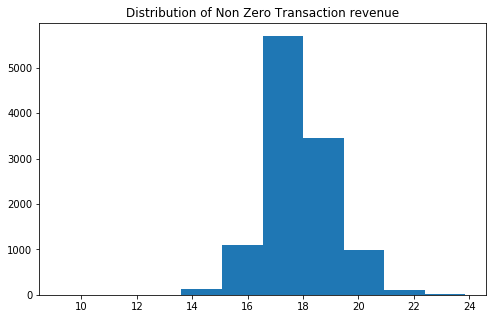

In [24]:
plt.hist(np.log1p(train_df[train_df['totals.transactionRevenue'] > 0]['totals.transactionRevenue']));
plt.rcParams['figure.figsize'] = [8.0, 5.0]
plt.title('Distribution of Non Zero Transaction revenue');
plt.show()

Description of SubContinent count: 
Northern America    390652
Southeast Asia       77799
Southern Asia        59320
Western Europe       59113
Northern Europe      58167
Eastern Asia         46919
Eastern Europe       45249
South America        41731
Name: geoNetwork.subContinent, dtype: int64


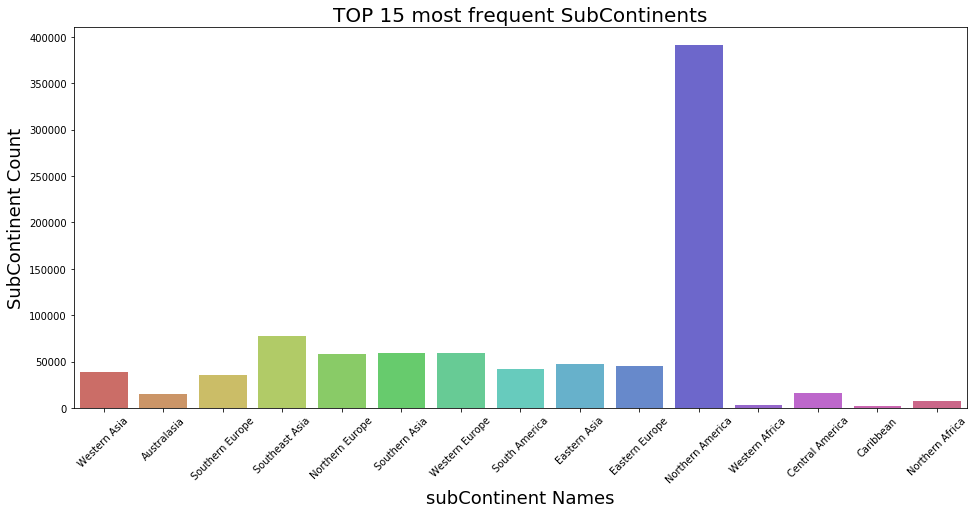

In [32]:
# Referred: Vivek Kumar Sah's kernel

import seaborn as sns

print("Description of SubContinent count: ")
print(train_df['geoNetwork.subContinent'].value_counts()[:8])
plt.figure(figsize=(16,7))

sns.countplot(train_df[train_df['geoNetwork.subContinent']\
                       .isin(train_df['geoNetwork.subContinent']\
                             .value_counts()[:15].index.values)]['geoNetwork.subContinent'], palette="hls") # It's a module to count the category's
plt.title("TOP 15 most frequent SubContinents", fontsize=20)
plt.xlabel("subContinent Names", fontsize=18)
plt.ylabel("SubContinent Count", fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [ ]:
crosstab_eda = pd.crosstab(index=df_train[df_train['device.operatingSystem']\
                                          .isin(df_train['device.operatingSystem']\
                                                .value_counts()[:6].index.values)]['device.operatingSystem'], 
                           
                           columns=df_train[df_train['device.browser'].isin(df_train['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])
crosstab_eda.plot(kind="bar", figsize=(14,7), stacked = True) 
plt.title("Most frequent OS's by Browsers of users", fontsize=22)
plt.xlabel("Operational System Name", fontsize=19)
plt.ylabel("Count OS", fontsize=19)
plt.xticks(rotation=0)
plt.show()

# Task - 4: Probability Function

In [96]:
def getTransactionRevenueLabel(revenue):
    if revenue > 0:
        return 1
    return 0

def getX(df):
    category_vars = [
         'device.deviceCategory', 
         'device.isMobile', 
         'geoNetwork.continent', 
         'geoNetwork.subContinent', 
         'channelGrouping'
    ]

    numerical_cols = [
        'totals.pageviews', 
        'totals.hits', 
        'visitNumber',
        'hour'
    ]
    
    X = df[category_vars]
    
    for cat in category_vars:
        X = X.join(pd.get_dummies(X[cat], prefix = cat))
        
    for col in numerical_cols:
        X[col] = df[col];
        
    X.drop(category_vars, axis = 1, inplace = True)

    return X;

visitor_id = train_df['fullVisitorId']
X_train = getX(train_df)
y_train = train_df["totals.transactionRevenue"].apply(getTransactionRevenueLabel);

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
probabilities = logreg.predict_proba(X_test)

buying_score = pd.DataFrame({'probability' : probabilities[:, 1], 'fullVisitorId' : visitor_id})
buying_score.sort_values(by = 'probability', ascending = False).head(10)['fullVisitorId']

321462     743123551680199202
838596    9894955795481014038
88736     6879336706336070910
456141    9264804092676520813
456142    3924372865099736100
665266    9894955795481014038
138750    8942866004645538967
321795    7344519175727343086
600775    5526675926038480325
600774    4983264713224875783
Name: fullVisitorId, dtype: object

In [104]:
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
gdf.sort_values(by=['totals.transactionRevenue'], ascending = False).head(10)

,fullVisitorId,totals.transactionRevenue
139588,1957458976293878100,7.711343e+10
401720,5632276788326171571,1.602375e+10
672533,9417857471295131045,1.517012e+10
318930,4471415710206918415,1.121110e+10
355403,4984366501121503466,9.513900e+09
649227,9089132392240687728,8.951970e+09
644983,9029794295932939024,7.846350e+09
532803,7463172420271311409,7.225100e+09
521949,7311242886083854158,7.143250e+09
565531,79204932396995037,7.047150e+09


# Task - 6: Kaggle Submission

In [89]:
# Referred: https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue

train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", 
            "device.browser", 
            "device.deviceCategory", 
            "device.operatingSystem", 
            "geoNetwork.city", 
            "geoNetwork.continent", 
            "geoNetwork.country", 
            "geoNetwork.metro",
            "geoNetwork.networkDomain", 
            "geoNetwork.region", 
            "geoNetwork.subContinent", 
            "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", 
            "trafficSource.campaign",
            "trafficSource.keyword",
            "trafficSource.medium", 
            "trafficSource.referralPath", 
            "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 
            'trafficSource.isTrueDirect',
            'hour',
            'month']

for col in cat_cols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

num_cols = [
    "totals.hits", 
    "totals.pageviews", 
    "visitNumber", 
    "visitStartTime", 
    'totals.bounces',  
    'totals.newVisits']

for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date'] <= datetime.date(2017,5,31)]
val_df = train_df[train_df['date'] > datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 

In [90]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.701
[200]	valid_0's rmse: 1.68972
[300]	valid_0's rmse: 1.6892
[400]	valid_0's rmse: 1.68929
Early stopping, best iteration is:
[326]	valid_0's rmse: 1.68807


In [91]:
from sklearn import metrics

pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
original_mse = (np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
print(original_mse)

1.7002053046959038


In [92]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

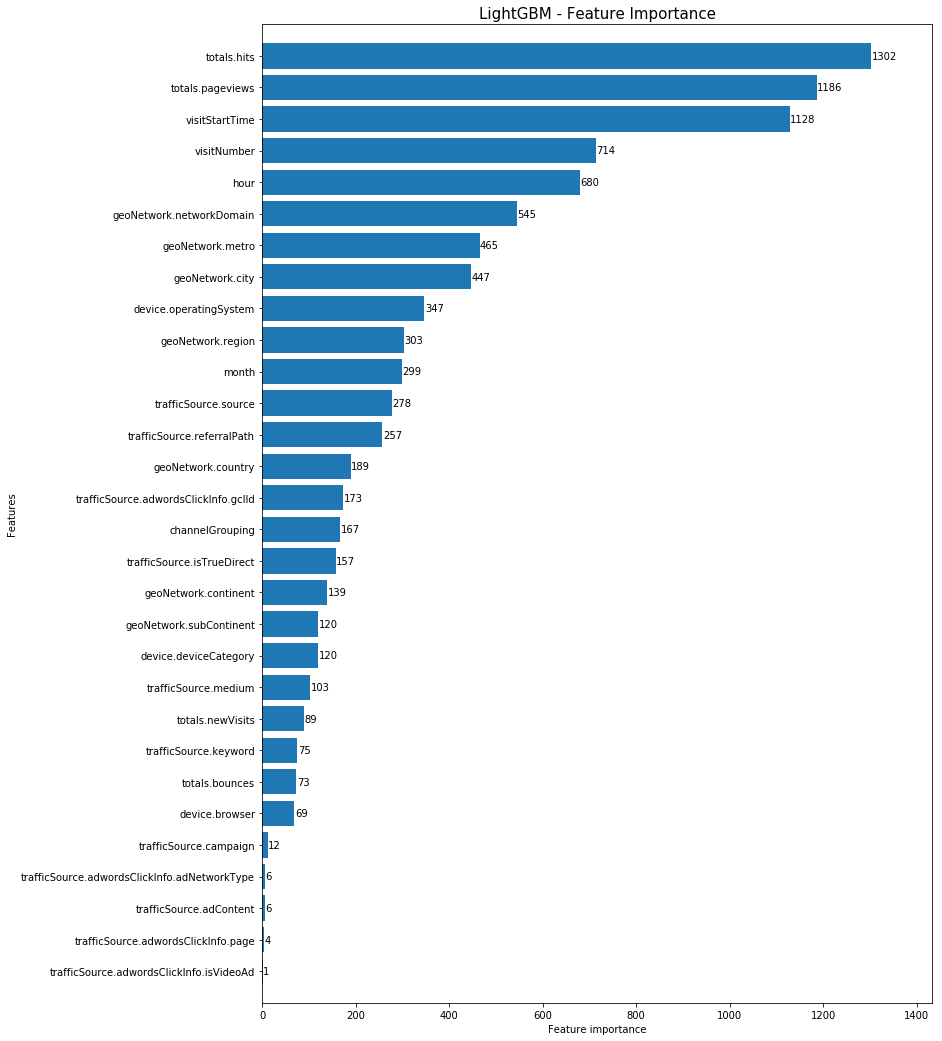

In [93]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

# Task 7: Permutation test

In [94]:
permute_cols = [
    'trafficSource.adwordsClickInfo.isVideoAd',
    'trafficSource.adwordsClickInfo.page',
    'totals.pageviews',
    'totals.hits', 
    'visitStartTime', 
    'visitNumber'
]

tol = 0.03
for col in permute_cols:
    print("Running for col:" + col)
    
    mseList = []
    for i in range(10):
        new_dev_X = dev_X
        new_dev_X[col] = np.random.permutation(new_dev_X[col])
    
        pred_test, model, pred_val = run_lgb(new_dev_X, dev_y, val_X, val_y, test_X)
    
        pred_val[pred_val<0] = 0
        val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
        val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
        val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
        val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
    
        mseList.append(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
    
    avg_mse = sum(mseList) / len(mseList)
    if abs(original_mse - avg_mse) > tol:
        print("Col [%s] is significantly impacting MSE by factor of %f" % (col, abs(original_mse - avg_mse)))
    else:
        print("Col [%s] is not significantly impacting MSE" % (col))

Running for col:trafficSource.adwordsClickInfo.isVideoAd


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70104
[200]	valid_0's rmse: 1.69053
[300]	valid_0's rmse: 1.68965
[400]	valid_0's rmse: 1.69004
Early stopping, best iteration is:
[337]	valid_0's rmse: 1.68879
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.701
[200]	valid_0's rmse: 1.69137
[300]	valid_0's rmse: 1.69007
Early stopping, best iteration is:
[288]	valid_0's rmse: 1.68981
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69997
[200]	valid_0's rmse: 1.6912
[300]	valid_0's rmse: 1.69189
Early stopping, best iteration is:
[222]	valid_0's rmse: 1.69074
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70199
[200]	valid_0's rmse: 1.69028
[300]	valid_0's rmse: 1.69029
Early stopping, best iteration is:
[256]	valid_0's rmse: 1.68934
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70104
[200]	va

[100]	valid_0's rmse: 2.05308
[200]	valid_0's rmse: 2.05577
Early stopping, best iteration is:
[102]	valid_0's rmse: 2.05197
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.05634
Early stopping, best iteration is:
[48]	valid_0's rmse: 2.05124
Col [totals.hits] is significantly impacting MSE by factor of 0.403256
Running for col:visitStartTime
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.05695
Early stopping, best iteration is:
[47]	valid_0's rmse: 2.05267
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.06162
Early stopping, best iteration is:
[33]	valid_0's rmse: 2.05426
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.05616
Early stopping, best iteration is:
[47]	valid_0's rmse: 2.05226
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.04664
[200]	valid_0's rmse: 2.03906
Early stopping, best i